***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

#### Read Data

In [5]:
df=pd.read_csv('../html/HTML.csv',index_col='domain')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df.columns if 'number' in col]
df.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df.shape)

df.Target=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

Shape of HTML dataset: (43491, 1461)


#### Dropping constants

In [6]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)


#### 95% same values

In [7]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [8]:
df.drop(col_values[col_values['95_%_same_values']==True].index.values,axis=1,inplace=True)

#### Dropping columns based on high VIF values

In [9]:
df_sel=df.copy(deep=True)
rem=['a_href_absolute','a_href_relative','a_count','a_href_out_of_domain',
     'base_count','base_href_absolute','base_href_out_of_domain',
     'iframe_src_absolute','iframe_src_relative','iframe_sandbox_allow_same_origin_count','iframe_src_http',
     'img_src_absolute','img_src_http','img_srcset_absolute','img_src_relative','img_srcset_relative','img_count',
     'script_src_absolute','script_src_http','script_src_relative','script_count','script_src_https',
     'link_rel_wlwmanifest','link_href_absolute','link_href_relative','link_rel_EditURI','link_count',
     'link_type_application/wlwmanifest+xml','link_href_https','link_rel_stylesheet','link_href_.png',
     'form_action_absolute','form_action_relative','form_count','form_action_https',
     'form_enctype_application/x-www-form-urlencoded',
     'tbody_count',
     'nofollow_count']

df_sel.drop(rem,axis=1,inplace=True)

In [10]:
X=df_sel.iloc[:,df_sel.columns!='Target']
Y=df_sel.Target

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [12]:
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(model.feature_importances_)

Accuracy: 90.11%


In [15]:
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(random_state=0)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90.11%
Thresh=0.000, n=125, Accuracy: 90

In [13]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.009, prefit=True)
# selection = SelectFromModel(model, threshold=0.012, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(random_state=0)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

selection_model = selection.get_support()
embeded_rf_feature = X.loc[:,selection_model].columns.tolist()

In [14]:
embeded_rf_feature.append('Target')
embeded_rf_feature

['a_href_.aspx',
 'a_href_.com',
 'a_href_http',
 'a_href_https',
 'b_count',
 'br_count',
 'center_count',
 'div_count',
 'form_action_http',
 'form_action_out_of_domain',
 'h1_count',
 'iframe_src_https',
 'img_src_.jpg',
 'input_count',
 'li_count',
 'link_href_.css',
 'link_href_0',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_application/rss+xml',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'script_charset_UTF-8',
 'script_defer_true',
 'script_src_.js',
 'script_src_out_of_domain',
 'script_type_text/javascript',
 'section_count',
 'span_count',
 'strong_count',
 'title_count',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [15]:
fin_col=embeded_rf_feature

In [16]:
df_sel=df_sel[fin_col]

In [18]:
train=df_sel.iloc[:30444,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel[fin_col].iloc[30444:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [19]:
columns=fin_col
columns.remove('Target')

In [20]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9069767441860465
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23628  2388    26016
True         444  3984     4428
__all__    24072  6372    30444

Accuracy of the model for test data is: 0.9054955162106232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10073  1025    11098
True         208  1741     1949
__all__    10281  2766    13047



Logistic Regression
Accuracy of the model for training data is: 0.8881881487320983
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23638  2378    26016
True        1026  3402     4428
__all__    24664  5780    30444

Accuracy of the model for test data is: 0.8877136506476585
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10085  1013    11098
True         452  1497     1949
__all__    10537  2510    13047



RandomForest Classifier
Accuracy of the model for training data is: 0.9174221521482065
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23700  2316    26016
True         198  4230     4428
__all__    23898  6546    30444

Accuracy of the model for test data is: 0.9082547712117728
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10101   997    11098
True         200  1749     1949
__all__    10301  2746    13047



Adaoost Classifier
Accuracy of the model for training data is: 0.8955130731835501
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23541  2475    26016
True         706  3722     4428
__all__    24247  6197    30444

Accuracy of the model for test data is: 0.8953016019008201
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10040  1058    11098
True         308  1641     1949
__all__    10348  2699    13047



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9036263303113914
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23682  2334    26016
True         600  3828     4428
__all__    24282  6162    30444

Accuracy of the model for test data is: 0.902046447459186
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10094  1004    11098
True         274  1675     1949
__all__    10368  2679    13047



ExtraTree Classifier
Accuracy of the model for training data is: 0.9199513861516226
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23706  2310    26016
True         127  4301     4428
__all__    23833  6611    30444

Accuracy of the model for test data is: 0.9091745228788227
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10109   989    11098
True         196  1753     1949
__all__    10305  2742    13047



Bagging Classifier
Accuracy of the model for training data is: 0.917684929707003
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23700  2316    26016
True         190  4238     4428
__all__    23890  6554    30444

Accuracy of the model for test data is: 0.9071817276002146
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10078  1020    11098
True         191  1758     1949
__all__    10269  2778    13047



Neural Network-1
The accuracy of the model on training data is: 0.911345421101038


Predicted  False  True  __all__
Actual                         
False      23624  2392    26016
True         307  4121     4428
__all__    23931  6513    30444

The accuracy of the model on test data is: 0.8982907948187323


Predicted  False  True  __all__
Actual                         
False      10002  1096    11098
True         231  1718     1949
__all__    10233  2814    13047

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [21]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [22]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.906977,3984.0,23628.0,2388.0,444.0,0.091790,0.100271
LogisticRegression,0.888188,3402.0,23638.0,2378.0,1026.0,0.091405,0.231707
RandomForestClassifier,0.917422,4230.0,23700.0,2316.0,198.0,0.089022,0.044715
AdaBoostClassifier,0.895513,3722.0,23541.0,2475.0,706.0,0.095134,0.159440
GradientBoostingClassifier,0.903626,3828.0,23682.0,2334.0,600.0,0.089714,0.135501
ExtraTreeClassifier,0.919951,4301.0,23706.0,2310.0,127.0,0.088792,0.028681
BaggingClassifier,0.917685,4238.0,23700.0,2316.0,190.0,0.089022,0.042909
Neural Network-1,0.911345,4121.0,23624.0,2392.0,307.0,0.091943,0.069332


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.905496,1741.0,10073.0,1025.0,208.0,0.092359,0.106721,0.900460,0.698511
LogisticRegression,0.887714,1497.0,10085.0,1013.0,452.0,0.091278,0.231914,0.838404,0.612067
RandomForestClassifier,0.908255,1749.0,10101.0,997.0,200.0,0.089836,0.102617,0.903774,0.706165
AdaBoostClassifier,0.895302,1641.0,10040.0,1058.0,308.0,0.095332,0.158030,0.873319,0.657065
GradientBoostingClassifier,0.902046,1675.0,10094.0,1004.0,274.0,0.090467,0.140585,0.884474,0.678565
ExtraTreeClassifier,0.909175,1753.0,10109.0,989.0,196.0,0.089115,0.100564,0.905160,0.708969
BaggingClassifier,0.907182,1758.0,10078.0,1020.0,191.0,0.091908,0.097999,0.905046,0.705396
Neural Network-1,0.898291,1718.0,10002.0,1096.0,231.0,0.098757,0.118522,0.891361,0.678378


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [23]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [24]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

In [25]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.5963253382533825
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24993  1023    26016
True       19981  6035    26016
__all__    44974  7058    52032

Accuracy of the model for test data is: 0.836590787154135
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10551   547    11098
True        1585   364     1949
__all__    12136   911    13047



Logistic Regression
Accuracy of the model for training data is: 0.885570418204182
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      21180   4836    26016
True        1118  24898    26016
__all__    22298  29734    52032

Accuracy of the model for test data is: 0.8318387368743773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8976  2122    11098
True          72  1877     1949
__all__     9048  3999    13047



RandomForest Classifier
Accuracy of the model for training data is: 0.9463407134071341
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23603   2413    26016
True         379  25637    26016
__all__    23982  28050    52032

Accuracy of the model for test data is: 0.9067218517666896
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10038  1060    11098
True         157  1792     1949
__all__    10195  2852    13047



Adaoost Classifier
Accuracy of the model for training data is: 0.9030212177121771
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22289   3727    26016
True        1319  24697    26016
__all__    23608  28424    52032

Accuracy of the model for test data is: 0.8677856978615773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9498  1600    11098
True         125  1824     1949
__all__     9623  3424    13047



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9224707872078721
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22829   3187    26016
True         847  25169    26016
__all__    23676  28356    52032

Accuracy of the model for test data is: 0.8835747681459339
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9718  1380    11098
True         139  1810     1949
__all__     9857  3190    13047



ExtraTree Classifier
Accuracy of the model for training data is: 0.947109471094711
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23610   2406    26016
True         346  25670    26016
__all__    23956  28076    52032

Accuracy of the model for test data is: 0.9075649574614854
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10051  1047    11098
True         159  1790     1949
__all__    10210  2837    13047



Bagging Classifier
Accuracy of the model for training data is: 0.9463599323493235
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23605   2411    26016
True         380  25636    26016
__all__    23985  28047    52032

Accuracy of the model for test data is: 0.9051889323216065
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10016  1082    11098
True         155  1794     1949
__all__    10171  2876    13047



Neural Network-1
The accuracy of the model on training data is: 0.9357895141451414


Predicted  False   True  __all__
Actual                          
False      23077   2939    26016
True         402  25614    26016
__all__    23479  28553    52032

The accuracy of the model on test data is: 0.8842645818962214


Predicted  False  True  __all__
Actual                         
False       9723  1375    11098
True         135  1814     1949
__all__     9858  3189    13047

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [26]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [27]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.596325,6035.0,24993.0,1023.0,19981.0,0.039322,0.768027
LogisticRegression,0.885570,24898.0,21180.0,4836.0,1118.0,0.185886,0.042974
RandomForestClassifier,0.946341,25637.0,23603.0,2413.0,379.0,0.092751,0.014568
AdaBoostClassifier,0.903021,24697.0,22289.0,3727.0,1319.0,0.143258,0.050700
GradientBoostingClassifier,0.922471,25169.0,22829.0,3187.0,847.0,0.122502,0.032557
ExtraTreeClassifier,0.947109,25670.0,23610.0,2406.0,346.0,0.092482,0.013300
BaggingClassifier,0.946360,25636.0,23605.0,2411.0,380.0,0.092674,0.014606
Neural Network-1,0.935790,25614.0,23077.0,2939.0,402.0,0.112969,0.015452


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.836591,364.0,10551.0,547.0,1585.0,0.049288,0.813238,0.568737,0.192288
LogisticRegression,0.831839,1877.0,8976.0,2122.0,72.0,0.191206,0.036942,0.885926,0.596775
RandomForestClassifier,0.906722,1792.0,10038.0,1060.0,157.0,0.095513,0.080554,0.911967,0.710644
AdaBoostClassifier,0.867786,1824.0,9498.0,1600.0,125.0,0.144170,0.064135,0.895847,0.641451
GradientBoostingClassifier,0.883575,1810.0,9718.0,1380.0,139.0,0.124347,0.071319,0.902167,0.667110
ExtraTreeClassifier,0.907565,1790.0,10051.0,1047.0,159.0,0.094341,0.081580,0.912039,0.712122
BaggingClassifier,0.905189,1794.0,10016.0,1082.0,155.0,0.097495,0.079528,0.911488,0.707685
Neural Network-1,0.884265,1814.0,9723.0,1375.0,135.0,0.123896,0.069266,0.903419,0.669257


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [28]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [29]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (8856, 35)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5722673893405601
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4279   149     4428
True        3639   789     4428
__all__     7918   938     8856

Accuracy of the model for test data is: 0.8349812217367978
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10553   545    11098
True        1608   341     1949
__all__    12161   886    13047



Logistic Regression
Accuracy of the model for training data is: 0.8827913279132791
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3580   848     4428
True         190  4238     4428
__all__     3770  5086     8856

Accuracy of the model for test data is: 0.8261669349275695
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       8894  2204    11098
True          64  1885     1949
__all__     8958  4089    13047



RandomForest Classifier
Accuracy of the model for training data is: 0.9437669376693767
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4027   401     4428
True          97  4331     4428
__all__     4124  4732     8856

Accuracy of the model for test data is: 0.8997470682915613
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9908  1190    11098
True         118  1831     1949
__all__    10026  3021    13047



Adaoost Classifier
Accuracy of the model for training data is: 0.8910343270099368
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3776   652     4428
True         313  4115     4428
__all__     4089  4767     8856

Accuracy of the model for test data is: 0.8620372499425155
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9422  1676    11098
True         124  1825     1949
__all__     9546  3501    13047



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9107949412827462
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3872   556     4428
True         234  4194     4428
__all__     4106  4750     8856

Accuracy of the model for test data is: 0.8765999846708056
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9584  1514    11098
True          96  1853     1949
__all__     9680  3367    13047



ExtraTree Classifier
Accuracy of the model for training data is: 0.9471544715447154
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4038   390     4428
True          78  4350     4428
__all__     4116  4740     8856

Accuracy of the model for test data is: 0.9012799877366444
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9946  1152    11098
True         136  1813     1949
__all__    10082  2965    13047



Bagging Classifier
Accuracy of the model for training data is: 0.9426377597109304
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4026   402     4428
True         106  4322     4428
__all__     4132  4724     8856

Accuracy of the model for test data is: 0.8934620985667203
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9823  1275    11098
True         115  1834     1949
__all__     9938  3109    13047



Neural Network-1
The accuracy of the model on training data is: 0.9276196928097519


Predicted  False  True  __all__
Actual                         
False       3879   549     4428
True          92  4336     4428
__all__     3971  4885     8856

The accuracy of the model on test data is: 0.8592779949413658


Predicted  False  True  __all__
Actual                         
False       9349  1749    11098
True          87  1862     1949
__all__     9436  3611    13047

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [30]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [31]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.572267,789.0,4279.0,149.0,3639.0,0.033650,0.821816
LogisticRegression,0.882791,4238.0,3580.0,848.0,190.0,0.191509,0.042909
RandomForestClassifier,0.943767,4331.0,4027.0,401.0,97.0,0.090560,0.021906
AdaBoostClassifier,0.891034,4115.0,3776.0,652.0,313.0,0.147245,0.070687
GradientBoostingClassifier,0.910795,4194.0,3872.0,556.0,234.0,0.125565,0.052846
ExtraTreeClassifier,0.947154,4350.0,4038.0,390.0,78.0,0.088076,0.017615
BaggingClassifier,0.942638,4322.0,4026.0,402.0,106.0,0.090786,0.023939
Neural Network-1,0.927620,4336.0,3879.0,549.0,92.0,0.123984,0.020777


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.834981,341.0,10553.0,545.0,1608.0,0.049108,0.825038,0.562927,0.178317
LogisticRegression,0.826167,1885.0,8894.0,2204.0,64.0,0.198594,0.032837,0.884284,0.590604
RandomForestClassifier,0.899747,1831.0,9908.0,1190.0,118.0,0.107227,0.060544,0.916115,0.703286
AdaBoostClassifier,0.862037,1825.0,9422.0,1676.0,124.0,0.151018,0.063622,0.892680,0.631815
GradientBoostingClassifier,0.876600,1853.0,9584.0,1514.0,96.0,0.136421,0.049256,0.907161,0.663385
ExtraTreeClassifier,0.901280,1813.0,9946.0,1152.0,136.0,0.103802,0.069779,0.913209,0.702979
BaggingClassifier,0.893462,1834.0,9823.0,1275.0,115.0,0.114886,0.059005,0.913055,0.691204
Neural Network-1,0.859278,1862.0,9349.0,1749.0,87.0,0.157596,0.044638,0.898883,0.635618


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [33]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2415 features
EntitySet scattered to workers in 4.655 seconds
Elapsed: 00:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [34]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [35]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [36]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)



X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [40]:
columns_mod=['link_href_0 + script_src_.js',
 'form_action_out_of_domain + script_src_.js',
 'div_count + meta_count',
 'center_count + script_src_.js',
 'script_type_text/javascript + title_count',
 'script_src_.js / title_count',
 'script_src_.js / link_href_.css',
 'script_src_.js + script_src_out_of_domain',
 'script_src_.js',
 'script_async_true + script_src_out_of_domain',
 'script_async_true + script_src_.js',
 'link_type_text/css + script_src_.js',
 'link_type_application/rss+xml + script_src_.js',
 'link_type_application/rsd+xml + script_src_.js',
 'link_rel_shortlink + script_src_.js',
 'link_href_out_of_domain + script_type_text/javascript',
 'link_href_out_of_domain + script_async_true',
 'link_href_.css + script_src_.js',
 'img_src_.jpg + script_src_.js',
 'img_src_.jpg + script_async_true',
 'img_src_.jpg + link_href_out_of_domain',
 'iframe_src_https + script_src_out_of_domain',
 'iframe_src_https + script_src_.js',
 'form_action_out_of_domain + script_src_out_of_domain',
 'form_action_http + script_src_.js',
 'div_count + script_src_.js',
 'div_count + p_count',
 'div_count + li_count',
 'br_count + div_count',
 'a_href_https + div_count',
 'a_href_http + div_count']

In [41]:
X=fs[columns_mod]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 31)

In [42]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['link_href_0 + script_src_.js',
 'form_action_out_of_domain + script_src_.js',
 'div_count + meta_count',
 'center_count + script_src_.js',
 'script_type_text/javascript + title_count',
 'script_src_.js / title_count',
 'script_src_.js / link_href_.css',
 'script_src_.js + script_src_out_of_domain',
 'script_src_.js',
 'script_async_true + script_src_out_of_domain',
 'script_async_true + script_src_.js',
 'link_type_text/css + script_src_.js',
 'link_type_application/rss+xml + script_src_.js',
 'link_type_application/rsd+xml + script_src_.js',
 'link_rel_shortlink + script_src_.js',
 'link_href_out_of_domain + script_type_text/javascript',
 'link_href_out_of_domain + script_async_true',
 'link_href_.css + script_src_.js',
 'img_src_.jpg + script_src_.js',
 'img_src_.jpg + script_async_true',
 'img_src_.jpg + link_href_out_of_domain',
 'iframe_src_https + script_src_out_of_domain',
 'iframe_src_https + script_src_.js',
 'form_action_out_of_domain + script_src_out_of_domain',
 'form_act

In [43]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:30444]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[30444:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [44]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9054986204178164
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23578  2438    26016
True         439  3989     4428
__all__    24017  6427    30444

Accuracy of the model for test data is: 0.9038093048210316
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10041  1057    11098
True         198  1751     1949
__all__    10239  2808    13047



Logistic Regression
Accuracy of the model for training data is: 0.8891407173827355
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23676  2340    26016
True        1035  3393     4428
__all__    24711  5733    30444

Accuracy of the model for test data is: 0.8879435885644209
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10096  1002    11098
True         460  1489     1949
__all__    10556  2491    13047



RandomForest Classifier
Accuracy of the model for training data is: 0.916338194718171
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23667  2349    26016
True         198  4230     4428
__all__    23865  6579    30444

Accuracy of the model for test data is: 0.907411665516977
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10087  1011    11098
True         197  1752     1949
__all__    10284  2763    13047



Adaoost Classifier
Accuracy of the model for training data is: 0.8946590461174616
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23588  2428    26016
True         779  3649     4428
__all__    24367  6077    30444

Accuracy of the model for test data is: 0.8956081857898367
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10072  1026    11098
True         336  1613     1949
__all__    10408  2639    13047



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9019511233740638
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23664  2352    26016
True         633  3795     4428
__all__    24297  6147    30444

Accuracy of the model for test data is: 0.9011266957921361
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10089  1009    11098
True         281  1668     1949
__all__    10370  2677    13047



ExtraTree Classifier
Accuracy of the model for training data is: 0.9189659703061358
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23670  2346    26016
True         121  4307     4428
__all__    23791  6653    30444

Accuracy of the model for test data is: 0.907335019544723
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10079  1019    11098
True         190  1759     1949
__all__    10269  2778    13047



Bagging Classifier
Accuracy of the model for training data is: 0.9163710419130207
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23667  2349    26016
True         197  4231     4428
__all__    23864  6580    30444

Accuracy of the model for test data is: 0.9064919138499272
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10071  1027    11098
True         193  1756     1949
__all__    10264  2783    13047



Neural Network-1


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

The accuracy of the model on training data is: 0.900374458021285


Predicted  False  True  __all__
Actual                         
False      23628  2388    26016
True         645  3783     4428
__all__    24273  6171    30444

The accuracy of the model on test data is: 0.8976009810684449


Predicted  False  True  __all__
Actual                         
False      10066  1032    11098
True         304  1645     1949
__all__    10370  2677    13047

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [45]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.905499,3989.0,23578.0,2438.0,439.0,0.093712,0.099142
LogisticRegression,0.889141,3393.0,23676.0,2340.0,1035.0,0.089945,0.233740
RandomForestClassifier,0.916338,4230.0,23667.0,2349.0,198.0,0.090291,0.044715
AdaBoostClassifier,0.894659,3649.0,23588.0,2428.0,779.0,0.093327,0.175926
GradientBoostingClassifier,0.901951,3795.0,23664.0,2352.0,633.0,0.090406,0.142954
ExtraTreeClassifier,0.918966,4307.0,23670.0,2346.0,121.0,0.090175,0.027326
BaggingClassifier,0.916371,4231.0,23667.0,2349.0,197.0,0.090291,0.044490
Neural Network-1,0.900374,3783.0,23628.0,2388.0,645.0,0.091790,0.145664


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.903809,1751.0,10041.0,1057.0,198.0,0.095242,0.101591,0.901584,0.696637
LogisticRegression,0.887944,1489.0,10096.0,1002.0,460.0,0.090287,0.236018,0.836847,0.611019
RandomForestClassifier,0.907412,1752.0,10087.0,1011.0,197.0,0.091097,0.101077,0.903913,0.704813
AdaBoostClassifier,0.895608,1613.0,10072.0,1026.0,336.0,0.092449,0.172396,0.867577,0.652385
GradientBoostingClassifier,0.901127,1668.0,10089.0,1009.0,281.0,0.090917,0.144177,0.882453,0.675185
ExtraTreeClassifier,0.907335,1759.0,10079.0,1019.0,190.0,0.091818,0.097486,0.905348,0.705921
BaggingClassifier,0.906492,1756.0,10071.0,1027.0,193.0,0.092539,0.099025,0.904218,0.703491
Neural Network-1,0.897601,1645.0,10066.0,1032.0,304.0,0.092990,0.155977,0.875516,0.662939


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 102.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 102.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 102.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 102.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 102.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

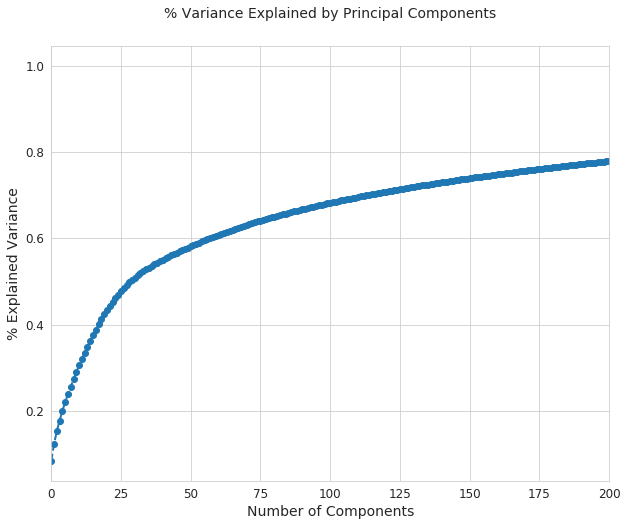

In [48]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [49]:
pca=PCA(n_components=250,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 250 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 250 components is: 0.8071736720285988


In [50]:
X_train=X_pca_21[:30444]
Y_train=fs.iloc[:30444]['Target'].values
X_test=X_pca_21[30444:]
Y_test=fs.iloc[30444:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [51]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,250).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9060241755354093
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23610  2406    26016
True         455  3973     4428
__all__    24065  6379    30444

Accuracy of the model for test data is: 0.903502720932015
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10051  1047    11098
True         212  1737     1949
__all__    10263  2784    13047



Logistic Regression
Accuracy of the model for training data is: 0.8978780712127185
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23580  2436    26016
True         673  3755     4428
__all__    24253  6191    30444

Accuracy of the model for test data is: 0.8933854525944661
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10013  1085    11098
True         306  1643     1949
__all__    10319  2728    13047



RandomForest Classifier
Accuracy of the model for training data is: 0.9169951386151622
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23702  2314    26016
True         213  4215     4428
__all__    23915  6529    30444

Accuracy of the model for test data is: 0.9089445849620602
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10120   978    11098
True         210  1739     1949
__all__    10330  2717    13047



Adaoost Classifier
Accuracy of the model for training data is: 0.9010314019182761
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23640  2376    26016
True         637  3791     4428
__all__    24277  6167    30444

Accuracy of the model for test data is: 0.9018165095424235
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10088  1010    11098
True         271  1678     1949
__all__    10359  2688    13047



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9069767441860465
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23711  2305    26016
True         527  3901     4428
__all__    24238  6206    30444

Accuracy of the model for test data is: 0.905418870238369
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10116   982    11098
True         252  1697     1949
__all__    10368  2679    13047



ExtraTree Classifier
Accuracy of the model for training data is: 0.9199513861516226
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23706  2310    26016
True         127  4301     4428
__all__    23833  6611    30444

Accuracy of the model for test data is: 0.9085613551007895
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10114   984    11098
True         209  1740     1949
__all__    10323  2724    13047



Bagging Classifier
Accuracy of the model for training data is: 0.9171593745894101
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23702  2314    26016
True         208  4220     4428
__all__    23910  6534    30444

Accuracy of the model for test data is: 0.907411665516977
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10102   996    11098
True         212  1737     1949
__all__    10314  2733    13047



Neural Network-1
The accuracy of the model on training data is: 0.9151556957035869


Predicted  False  True  __all__
Actual                         
False      23638  2378    26016
True         205  4223     4428
__all__    23843  6601    30444

The accuracy of the model on test data is: 0.9001302981528321


Predicted  False  True  __all__
Actual                         
False       9994  1104    11098
True         199  1750     1949
__all__    10193  2854    13047

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [52]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [53]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.906024,3973.0,23610.0,2406.0,455.0,0.092482,0.102755
LogisticRegression,0.897878,3755.0,23580.0,2436.0,673.0,0.093635,0.151987
RandomForestClassifier,0.916995,4215.0,23702.0,2314.0,213.0,0.088945,0.048103
AdaBoostClassifier,0.901031,3791.0,23640.0,2376.0,637.0,0.091328,0.143857
GradientBoostingClassifier,0.906977,3901.0,23711.0,2305.0,527.0,0.088599,0.119015
ExtraTreeClassifier,0.919951,4301.0,23706.0,2310.0,127.0,0.088792,0.028681
BaggingClassifier,0.917159,4220.0,23702.0,2314.0,208.0,0.088945,0.046974
Neural Network-1,0.915156,4223.0,23638.0,2378.0,205.0,0.091405,0.046296


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.903503,1737.0,10051.0,1047.0,212.0,0.094341,0.108774,0.898442,0.693349
LogisticRegression,0.893385,1643.0,10013.0,1085.0,306.0,0.097765,0.157004,0.872616,0.653248
RandomForestClassifier,0.908945,1739.0,10120.0,978.0,210.0,0.088124,0.107748,0.902064,0.705925
AdaBoostClassifier,0.901817,1678.0,10088.0,1010.0,271.0,0.091007,0.139046,0.884973,0.678603
GradientBoostingClassifier,0.905419,1697.0,10116.0,982.0,252.0,0.088484,0.129297,0.891109,0.690276
ExtraTreeClassifier,0.908561,1740.0,10114.0,984.0,209.0,0.088665,0.107234,0.902050,0.705232
BaggingClassifier,0.907412,1737.0,10102.0,996.0,212.0,0.089746,0.108774,0.900740,0.702082
Neural Network-1,0.900130,1750.0,9994.0,1104.0,199.0,0.099477,0.102104,0.899209,0.688464


In [54]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')